# Mixed Precision Training of CNN

Author: Amir Fawwaz

Affliation: Twistcode® Technologies Sdn. Bhd., Cyberjaya, Malaysia

Published: 9 January 2023

## Introduction

In this example, we will speed-up the training of a simple CNN with mixed precision to perform image classification on the [RSNA dataset](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/data). For example, using the NVIDIA RTX 2080 Ti GPU on personal PC, we can reduce the training time (using the same model and batch size) over 100 epochs from about 303.67 seconds (FP32) to less than 223 seconds with mixed precision, without sacrificing classification accuracy.

## Some basic on mixed precision

**Mixed precision** is the use of both float16 and float32 data types when training a model.

Performing arithmetic operations in float16 takes advantage of the performance gains of using specialized processing units such as the Tensor cores. Due to the smaller representable range of float16, performing the entire training with float16 data type can result in underflow of the gradients, leading to convergence or model quality issues.

However, _performing only select arithmetic operations_ in float16 results in performance gains when using compatible hardware accelerators, decreasing training time and reducing memory usage, typically without sacrificing model performance.

## TensorFlow Automatic Mixed Precision API

The method presented in this notebook is the API used in TensorFlow 2.10.1 with the following PC specification:

+ Windows 11 Pro
+ python 3.8.10
+ CUDA 11.2
+ cuDNN 8.1.1

> Note: This notebook was originally run on PC with Nvidia RTX 2080 Ti. For this github repo, i rerun in laptop with Nvidia MX150

For more details, you can consult this relevant [TensorFlow documentation](https://www.tensorflow.org/guide/mixed_precision).

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import os
import warnings
import random
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Set seed for experiment reproducibility
seed=1234
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())

2.10.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
BATCH_SIZE_PER_REPLICA = 64  # you may change to make training faster (if memory is available)
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync
print('BATCH_SIZE = ',BATCH_SIZE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
BATCH_SIZE =  64


In [5]:
image_size = (124, 124)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "../curated_data",
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=BATCH_SIZE,
)

Found 4494 files belonging to 2 classes.
Using 3596 files for training.
Using 898 files for validation.


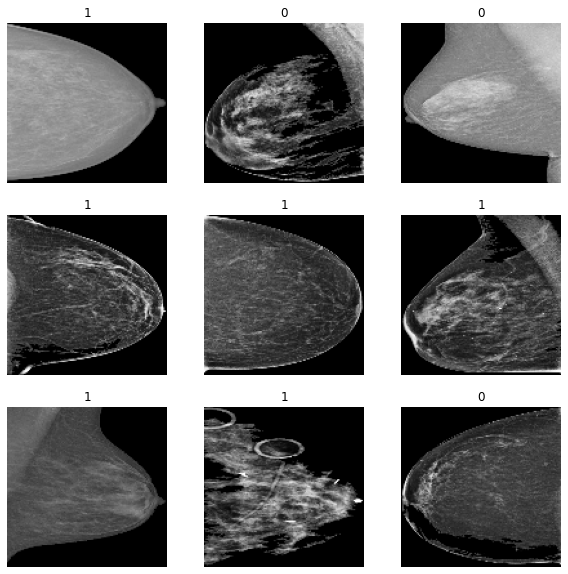

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [8]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    
def my_deep_model(input_shape, num_classes):
    
    # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
    # the three color channels: R, G, and B
    img_input = layers.Input(shape=input_shape)

    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv2D(32, 3, activation='relu')(img_input)
    x = layers.MaxPooling2D(2)(x)

    # Second convolution extracts 32 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Third convolution extracts 64 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Flatten feature map to a 1-dim tensor so we can add fully connected layers
    x = layers.Flatten()(x)

    # Create a fully connected layer with ReLU activation and 512 hidden units
    x = layers.Dense(100, activation='relu')(x)

    # Create output layer with a single node and sigmoid activation
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    output = layers.Dense(units, activation=activation)(x)
    
    model = Model(img_input, output)
    
    return model

In [9]:
with mirrored_strategy.scope():
    model = my_deep_model(input_shape=image_size + (3,), num_classes=2)
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496 

In [10]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(patience=15, \
                                                      monitor="val_loss", mode="auto", \
                                                      restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("../model/normal_training.h5", save_best_only=True)

In [11]:
# train
epochs = 25

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

start = time.time()

%time history = model.fit(train_ds,epochs=epochs,\
                          callbacks=[earlystop_callback, checkpoint_callback],\
                          validation_data=val_ds,verbose=2)
print("It took {} seconds".format(time.time() - start))
print("Training Finish")

total_training_time_1 = time.time() - start

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/25
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

In [12]:
model.evaluate(val_ds,return_dict=True)

15/15 [==============================] - 1s 52ms/step - loss: 0.7398 - accuracy: 0.4855


{'loss': 0.7397844791412354, 'accuracy': 0.48552337288856506}

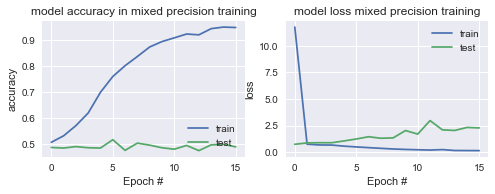

In [13]:
# summarize history for accuracy
plt.style.use("seaborn")
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy in mixed precision training')
plt.ylabel('accuracy')
plt.xlabel("Epoch #")
plt.legend(['train', 'test'], loc='lower right')

# summarize history for loss
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss mixed precision training')
plt.ylabel('loss')
plt.xlabel("Epoch #")
plt.legend(['train', 'test'], loc='upper right')
resolution_value = 1200
plt.savefig('../asset/train_info.jpg', format="jpg", dpi=resolution_value)
plt.show()

## Reference

1. [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)